In [493]:
import json
import pandas as pd
import numpy as np
import spotipy
import requests
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
import os
from collections import defaultdict


In [494]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [495]:

username = os.environ.get("USERNAME")
client_id = os.environ.get("CLIENT_ID")
client_secret = os.environ.get("CLIENT_SECRET")
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'
data_path = f"./{username}_data"
prefix = f"{username}_"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                                client_secret,     
                                                scope=scope, 
                                                redirect_uri=redirect_uri,
                                                username=username))

In [496]:
identifiers_string = open(f"{data_path}/{prefix}Identifiers.json", "r").read()
identifiers_json = json.loads(identifiers_string)

inferences_string = open(f"{data_path}/{prefix}Inferences.json", "r").read()
inferences_json = json.loads(inferences_string)

marquee_string = open(f"{data_path}/{prefix}Marquee.json", "r").read()
marquee_json = json.loads(marquee_string)

playlist_string = open(f"{data_path}/{prefix}Playlist1.json", "r").read()
playlist_json = json.loads(playlist_string)

search_string = open(f"{data_path}/{prefix}SearchQueries.json", "r").read()
search_json = json.loads(search_string)

library_string = open(f"{data_path}/{prefix}YourLibrary.json", "r").read()
library_json = json.loads(library_string)

In [497]:
import ast
from typing import List
from os import listdir
def get_streamings(path: str) -> List[dict]:
    
    files = [f"{data_path}/{x}" for x in listdir(path)
             if x.split('.')[0][:-1] == prefix+'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [498]:
# from collections import defaultdict

# streamings = get_streamings(data_path)

# exceptions = 0
# tracks_to_ids = defaultdict()
# for i in range(len(streamings)):
#    track_name = streamings[i]['trackName']
#    if track_name in tracks_to_ids:
#       streamings[i]['id'] = tracks_to_ids[track_name]
#    else:
#       search = sp.search(q=f"track:{track_name}",type="track")
#       try:
#          id = search['tracks']['items'][0]['id']
#          streamings[i]['id'] = id
#       except: #          tracks_to_ids[track_name] = None

# with open(f'{data_path}/{prefix}history_with_ids', 'w') as f:
#    f.write(json.dumps(streamings, indent=2))
#
# nones = 0
# for x, y in tracks_to_ids.items():
#      if y == None:
#         nones+=1

# print(nones)

In [499]:
tracks_file = open(f'{data_path}/{prefix}history_with_ids', 'r')
tracks = json.load(tracks_file)
# drop any rows without an id
indices_to_remove = []
for i in range(len(tracks)):
   try:
      tracks[i]['id']
   except KeyError:
      indices_to_remove.append(i)
      print(tracks[i])

tracks_result = []
prev = 0
for x in indices_to_remove:
   tracks_result += tracks[prev + 1: x]
   prev = x
tracks_clean = tracks_result

{'endTime': '2021-08-17 22:55', 'artistName': 'LILHUDDY', 'trackName': "Don't Freak Out (feat. iann dior, Tyson Ritter & Travis Barker)", 'msPlayed': 156000}
{'endTime': '2021-08-27 02:13', 'artistName': 'Derek Pope', 'trackName': "Don't Make Me Feel Alone", 'msPlayed': 211099}
{'endTime': '2021-08-30 07:19', 'artistName': 'Foals', 'trackName': "I'm Done With The World (& It's Done With Me)", 'msPlayed': 182030}
{'endTime': '2021-09-02 16:36', 'artistName': 'Murge', 'trackName': "Can't Hurt Me Now", 'msPlayed': 359572}
{'endTime': '2021-09-03 01:27', 'artistName': 'James Blake', 'trackName': "Can't Believe The Way We Flow", 'msPlayed': 267200}
{'endTime': '2021-09-03 02:19', 'artistName': 'John Rzeznik', 'trackName': 'I\'m Still Here (Jim\'s Theme) - From "Treasure Planet"/Soundtrack Version', 'msPlayed': 251466}
{'endTime': '2021-09-10 01:04', 'artistName': 'The Tiny Meat Gang Podcast', 'trackName': 'Ep 202 - Cody got a haircut ft. Ben Cahn and Emil DeRosa', 'msPlayed': 847760}
{'endT

In [500]:
tracks_df = pd.DataFrame(tracks).dropna(subset=["id"], axis=0)
unique_ids = tracks_df['id'].unique()
block = 0
features = []
while(len(unique_ids) - block > 0):
   ids = unique_ids[block:block + 100]
   block+=100
   features += sp.audio_features(ids)

In [501]:

features = temp = np.array(features)
features = list(temp[~pd.isna(temp)])

In [502]:
# AFTER RUNNING THE TWO QUERIES THIS SHOULD BE THE FINAL FILE WITH SONG IDS AND FEATURES OF EACH
pd.merge(tracks_df, pd.DataFrame(features), on='id', how='left').to_csv(f'{data_path}/{prefix}history_with_features', index=False)
dataset_detailed_df = pd.read_csv(f'{data_path}/{prefix}history_with_features')


In [503]:
dataset_detailed_df

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2021-08-17 22:43,Trippie Redd,LEADERS,160993,4D7NrSeqkTarBrJ80b2sBc,0.950,0.654,0.0,-5.895,0.0,...,0.000000,0.1380,0.886,132.936,audio_features,spotify:track:4D7NrSeqkTarBrJ80b2sBc,https://api.spotify.com/v1/tracks/4D7NrSeqkTar...,https://api.spotify.com/v1/audio-analysis/4D7N...,194844.0,4.0
1,2021-08-17 22:47,Trippie Redd,FROZEN OCEAN,196169,5ypQ8scn8g2l0341ErES0B,0.314,0.762,2.0,-3.136,1.0,...,0.000022,0.1160,0.310,134.582,audio_features,spotify:track:5ypQ8scn8g2l0341ErES0B,https://api.spotify.com/v1/tracks/5ypQ8scn8g2l...,https://api.spotify.com/v1/audio-analysis/5ypQ...,204233.0,4.0
2,2021-08-17 22:49,WILLOW,t r a n s p a r e n t s o u l feat. Travis Barker,168398,1QL7nSDZCwZMnbisV4KOXt,0.390,0.830,11.0,-5.201,0.0,...,0.000000,0.1560,0.191,90.021,audio_features,spotify:track:1QL7nSDZCwZMnbisV4KOXt,https://api.spotify.com/v1/tracks/1QL7nSDZCwZM...,https://api.spotify.com/v1/audio-analysis/1QL7...,168030.0,4.0
3,2021-08-17 22:52,Machine Gun Kelly,I Think I'm OKAY (with YUNGBLUD & Travis Barker),169397,2gTdDMpNxIRFSiu7HutMCg,0.628,0.744,7.0,-4.718,1.0,...,0.000000,0.3130,0.277,119.921,audio_features,spotify:track:2gTdDMpNxIRFSiu7HutMCg,https://api.spotify.com/v1/tracks/2gTdDMpNxIRF...,https://api.spotify.com/v1/audio-analysis/2gTd...,169397.0,4.0
4,2021-08-17 22:58,Trippie Redd,PILL BREAKER (feat. blackbear & Machine Gun Ke...,177058,7jjnn6K7p5MgOFuqLypAcM,0.527,0.790,2.0,-6.268,1.0,...,0.000000,0.3700,0.236,153.034,audio_features,spotify:track:7jjnn6K7p5MgOFuqLypAcM,https://api.spotify.com/v1/tracks/7jjnn6K7p5Mg...,https://api.spotify.com/v1/audio-analysis/7jjn...,177059.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12658,2021-08-17 22:29,Trippie Redd,RED SKY (feat. Machine Gun Kelly),152149,0yFfjXtSDkr81WVAPPS1Q4,0.472,0.769,7.0,-4.198,1.0,...,0.000000,0.2390,0.587,159.999,audio_features,spotify:track:0yFfjXtSDkr81WVAPPS1Q4,https://api.spotify.com/v1/tracks/0yFfjXtSDkr8...,https://api.spotify.com/v1/audio-analysis/0yFf...,152149.0,4.0
12659,2021-08-17 22:33,Trippie Redd,MEGLADON,194992,5Kq6LIFZsVD99rb7iT0QTG,0.453,0.739,7.0,-4.977,1.0,...,0.000000,0.6940,0.258,139.962,audio_features,spotify:track:5Kq6LIFZsVD99rb7iT0QTG,https://api.spotify.com/v1/tracks/5Kq6LIFZsVD9...,https://api.spotify.com/v1/audio-analysis/5Kq6...,194992.0,4.0
12660,2021-08-17 22:35,Trippie Redd,SAVE YOURSELF,160729,6FhB5ZyT4JsIJ0ozDlXCIp,0.503,0.921,8.0,-5.907,0.0,...,0.000003,0.2600,0.359,121.983,audio_features,spotify:track:6FhB5ZyT4JsIJ0ozDlXCIp,https://api.spotify.com/v1/tracks/6FhB5ZyT4JsI...,https://api.spotify.com/v1/audio-analysis/6FhB...,221160.0,4.0
12661,2021-08-17 22:38,Trippie Redd,DREAMER,170000,4yZEX3NsnXfobmZ0m8ZO4Y,0.723,0.751,9.0,-5.233,0.0,...,0.000000,0.0680,0.642,126.999,audio_features,spotify:track:4yZEX3NsnXfobmZ0m8ZO4Y,https://api.spotify.com/v1/tracks/4yZEX3NsnXfo...,https://api.spotify.com/v1/audio-analysis/4yZE...,190849.0,4.0


In [504]:
# normalizing loudness and tempo
from sklearn import preprocessing

loudness = dataset_detailed_df[['loudness']].values
min_max_scaler = preprocessing.MinMaxScaler()
loudness_scaled = min_max_scaler.fit_transform(loudness)
dataset_detailed_df['loudness'] = loudness_scaled
dataset_detailed_df

tempo = dataset_detailed_df[['tempo']].values
min_max_scaler = preprocessing.MinMaxScaler()
tempo_scaled = min_max_scaler.fit_transform(tempo)
dataset_detailed_df['tempo'] = tempo_scaled
dataset_detailed_df

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2021-08-17 22:43,Trippie Redd,LEADERS,160993,4D7NrSeqkTarBrJ80b2sBc,0.950,0.654,0.0,0.870518,0.0,...,0.000000,0.1380,0.886,0.616847,audio_features,spotify:track:4D7NrSeqkTarBrJ80b2sBc,https://api.spotify.com/v1/tracks/4D7NrSeqkTar...,https://api.spotify.com/v1/audio-analysis/4D7N...,194844.0,4.0
1,2021-08-17 22:47,Trippie Redd,FROZEN OCEAN,196169,5ypQ8scn8g2l0341ErES0B,0.314,0.762,2.0,0.935684,1.0,...,0.000022,0.1160,0.310,0.624484,audio_features,spotify:track:5ypQ8scn8g2l0341ErES0B,https://api.spotify.com/v1/tracks/5ypQ8scn8g2l...,https://api.spotify.com/v1/audio-analysis/5ypQ...,204233.0,4.0
2,2021-08-17 22:49,WILLOW,t r a n s p a r e n t s o u l feat. Travis Barker,168398,1QL7nSDZCwZMnbisV4KOXt,0.390,0.830,11.0,0.886910,0.0,...,0.000000,0.1560,0.191,0.417713,audio_features,spotify:track:1QL7nSDZCwZMnbisV4KOXt,https://api.spotify.com/v1/tracks/1QL7nSDZCwZM...,https://api.spotify.com/v1/audio-analysis/1QL7...,168030.0,4.0
3,2021-08-17 22:52,Machine Gun Kelly,I Think I'm OKAY (with YUNGBLUD & Travis Barker),169397,2gTdDMpNxIRFSiu7HutMCg,0.628,0.744,7.0,0.898318,1.0,...,0.000000,0.3130,0.277,0.556455,audio_features,spotify:track:2gTdDMpNxIRFSiu7HutMCg,https://api.spotify.com/v1/tracks/2gTdDMpNxIRF...,https://api.spotify.com/v1/audio-analysis/2gTd...,169397.0,4.0
4,2021-08-17 22:58,Trippie Redd,PILL BREAKER (feat. blackbear & Machine Gun Ke...,177058,7jjnn6K7p5MgOFuqLypAcM,0.527,0.790,2.0,0.861708,1.0,...,0.000000,0.3700,0.236,0.710105,audio_features,spotify:track:7jjnn6K7p5MgOFuqLypAcM,https://api.spotify.com/v1/tracks/7jjnn6K7p5Mg...,https://api.spotify.com/v1/audio-analysis/7jjn...,177059.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12658,2021-08-17 22:29,Trippie Redd,RED SKY (feat. Machine Gun Kelly),152149,0yFfjXtSDkr81WVAPPS1Q4,0.472,0.769,7.0,0.910600,1.0,...,0.000000,0.2390,0.587,0.742424,audio_features,spotify:track:0yFfjXtSDkr81WVAPPS1Q4,https://api.spotify.com/v1/tracks/0yFfjXtSDkr8...,https://api.spotify.com/v1/audio-analysis/0yFf...,152149.0,4.0
12659,2021-08-17 22:33,Trippie Redd,MEGLADON,194992,5Kq6LIFZsVD99rb7iT0QTG,0.453,0.739,7.0,0.892201,1.0,...,0.000000,0.6940,0.258,0.649449,audio_features,spotify:track:5Kq6LIFZsVD99rb7iT0QTG,https://api.spotify.com/v1/tracks/5Kq6LIFZsVD9...,https://api.spotify.com/v1/audio-analysis/5Kq6...,194992.0,4.0
12660,2021-08-17 22:35,Trippie Redd,SAVE YOURSELF,160729,6FhB5ZyT4JsIJ0ozDlXCIp,0.503,0.921,8.0,0.870235,0.0,...,0.000003,0.2600,0.359,0.566023,audio_features,spotify:track:6FhB5ZyT4JsIJ0ozDlXCIp,https://api.spotify.com/v1/tracks/6FhB5ZyT4JsI...,https://api.spotify.com/v1/audio-analysis/6FhB...,221160.0,4.0
12661,2021-08-17 22:38,Trippie Redd,DREAMER,170000,4yZEX3NsnXfobmZ0m8ZO4Y,0.723,0.751,9.0,0.886154,0.0,...,0.000000,0.0680,0.642,0.589298,audio_features,spotify:track:4yZEX3NsnXfobmZ0m8ZO4Y,https://api.spotify.com/v1/tracks/4yZEX3NsnXfo...,https://api.spotify.com/v1/audio-analysis/4yZE...,190849.0,4.0


In [505]:
# format for kmenas, dropping non-numerical

dataset_detailed_df = dataset_detailed_df.dropna()
dataset_df = dataset_detailed_df.drop(['endTime', 'artistName', 'trackName', 'msPlayed', 'id', 'key', 'mode', 'type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'instrumentalness'], axis=1)
dataset_df

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo
0,0.950,0.654,0.870518,0.3070,0.07440,0.1380,0.886,0.616847
1,0.314,0.762,0.935684,0.0356,0.00429,0.1160,0.310,0.624484
2,0.390,0.830,0.886910,0.0563,0.00210,0.1560,0.191,0.417713
3,0.628,0.744,0.898318,0.0379,0.02570,0.3130,0.277,0.556455
4,0.527,0.790,0.861708,0.0788,0.01600,0.3700,0.236,0.710105
...,...,...,...,...,...,...,...,...
12658,0.472,0.769,0.910600,0.0419,0.02490,0.2390,0.587,0.742424
12659,0.453,0.739,0.892201,0.0515,0.00426,0.6940,0.258,0.649449
12660,0.503,0.921,0.870235,0.1060,0.00093,0.2600,0.359,0.566023
12661,0.723,0.751,0.886154,0.0450,0.41200,0.0680,0.642,0.589298


In [506]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_df)
    Sum_of_squared_distances.append(km.inertia_)

In [507]:


from sklearn.metrics import silhouette_score
for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(dataset_df)
    centers = clusterer.cluster_centers_

    score = silhouette_score (dataset_df, preds, metric='euclidean')



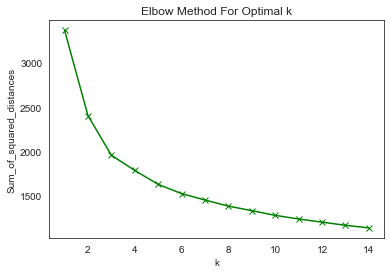

In [508]:
# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [509]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(dataset_df)

KMeans(n_clusters=5)

In [510]:
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(dataset_df)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(dataset_df)

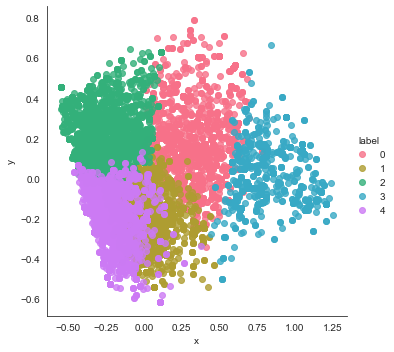

In [511]:
import seaborn as sns
#set style of plots
sns.set_style('white')

#define a custom palette

pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False)

In [512]:
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
#T-SNE with two dimensions
tsne = TSNE(n_components=2, perplexity=50)

tsne_components = tsne.fit_transform(dataset_df)

/Users/mcuento/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mcuento/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


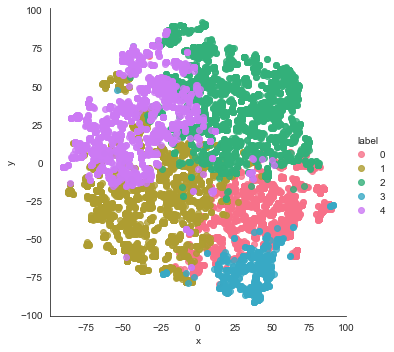

In [513]:
ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True)



In [514]:
print(pd.DataFrame(pca.components_,columns=dataset_df.columns,index = ['PC-1','PC-2']))

      danceability    energy  loudness  speechiness  acousticness  liveness  \
PC-1     -0.143128 -0.494645 -0.203839    -0.033720      0.742103 -0.055899   
PC-2      0.303127 -0.082120 -0.014507     0.085208      0.418193  0.006998   

       valence     tempo  
PC-1 -0.362872 -0.081458  
PC-2  0.847903 -0.005032  


In [515]:
dataset_detailed_df['label'] = y_kmeans

dataset_detailed_df = dataset_detailed_df.sample(frac=1)
dataset_detailed_df['label'].value_counts()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/2896304468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_detailed_df['label'] = y_kmeans


2    3683
1    3301
4    2601
0    2237
3     838
Name: label, dtype: int64

In [516]:
# Save newly created kmeans clusters
# dataset_detailed_df.to_excel('final_clusters.xlsx')
# dataset_df.to_excel('kmeans_input.xlsx')

# Reads from precomputed cluseters
dataset_detailed_df = pd.read_excel('final_clusters.xlsx', index_col=0)
dataset_df = pd.read_excel('kmeans_input.xlsx', index_col=0)
dataset_detailed_df

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
8041,2021-03-09 17:14,KAYTRANADA,CHANCES,218200,2OdfQjIJlomZFUBTEDKMre,0.667,0.5400,7,0.837309,1,...,0.2180,0.0882,0.649551,audio_features,spotify:track:2OdfQjIJlomZFUBTEDKMre,https://api.spotify.com/v1/tracks/2OdfQjIJlomZ...,https://api.spotify.com/v1/audio-analysis/2Odf...,226449,4,3
8671,2021-03-22 02:24,PRICE,Selfish,33744,2xbI8Vmyv3TkpTdywpPyNw,0.638,0.6000,1,0.871817,0,...,0.1870,0.0399,0.473210,audio_features,spotify:track:2xbI8Vmyv3TkpTdywpPyNw,https://api.spotify.com/v1/tracks/2xbI8Vmyv3Tk...,https://api.spotify.com/v1/audio-analysis/2xbI...,245604,4,3
12228,2021-08-09 20:59,Mono/Poly,AS LONG AS THAT LOVE IS DIVINE,292320,7IZJ77l62dgOeHwoKzJQTv,0.698,0.8450,5,0.895437,1,...,0.3260,0.2080,0.580101,audio_features,spotify:track:7IZJ77l62dgOeHwoKzJQTv,https://api.spotify.com/v1/tracks/7IZJ77l62dgO...,https://api.spotify.com/v1/audio-analysis/7IZJ...,292320,4,0
1880,2021-10-04 23:15,Oski,Go My Way,233600,45Ia1U4KtIjAPPU7Wv1Sea,0.619,0.6700,11,0.765955,0,...,0.3310,0.7770,0.599831,audio_features,spotify:track:45Ia1U4KtIjAPPU7Wv1Sea,https://api.spotify.com/v1/tracks/45Ia1U4KtIjA...,https://api.spotify.com/v1/audio-analysis/45Ia...,211933,4,4
413,2021-08-30 23:24,Third Eye Blind,Losing a Whole Year,200640,5lgOUdoMBB3eZuSmc5HL4r,0.421,0.8480,4,0.860952,1,...,0.0775,0.6580,0.815117,audio_features,spotify:track:5lgOUdoMBB3eZuSmc5HL4r,https://api.spotify.com/v1/tracks/5lgOUdoMBB3e...,https://api.spotify.com/v1/audio-analysis/5lgO...,200640,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2021-08-30 07:09,Jaden,Summertime In Paris,270960,6XNANAB7sFvkfho6bMCp7o,0.569,0.8600,9,0.912537,1,...,0.1530,0.2890,0.421964,audio_features,spotify:track:6XNANAB7sFvkfho6bMCp7o,https://api.spotify.com/v1/tracks/6XNANAB7sFvk...,https://api.spotify.com/v1/audio-analysis/6XNA...,270960,4,0
5399,2021-01-01 06:52,The S.O.S Band,Take Your Time (Do It Right),460800,4ctf7oL8fFRPvBstJCTYWu,0.863,0.5380,4,0.680878,0,...,0.0877,0.8770,0.551861,audio_features,spotify:track:4ctf7oL8fFRPvBstJCTYWu,https://api.spotify.com/v1/tracks/4ctf7oL8fFRP...,https://api.spotify.com/v1/audio-analysis/4ctf...,460800,4,4
7616,2021-02-20 05:25,Rastovich,Dream Factory,134505,5eGnL6MWBeRkilfxdGvTbK,0.813,0.6320,2,0.868038,1,...,0.0950,0.5450,0.742479,audio_features,spotify:track:5eGnL6MWBeRkilfxdGvTbK,https://api.spotify.com/v1/tracks/5eGnL6MWBeRk...,https://api.spotify.com/v1/audio-analysis/5eGn...,267113,4,1
11796,2021-07-27 14:01,Towkio,Reflection,47180,7H7NyZ3G075GqPx2evsfeb,0.538,0.5570,11,0.804785,1,...,0.1020,0.5060,0.608002,audio_features,spotify:track:7H7NyZ3G075GqPx2evsfeb,https://api.spotify.com/v1/tracks/7H7NyZ3G075G...,https://api.spotify.com/v1/audio-analysis/7H7N...,231724,4,3


In [517]:
dataset_detailed_df[dataset_detailed_df['label'] == 1].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/1919225646.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 1].mean()


msPlayed            166163.030398
danceability             0.633581
energy                   0.516413
key                      4.953956
loudness                 0.795137
mode                     0.625391
speechiness              0.129838
acousticness             0.591279
instrumentalness         0.121948
liveness                 0.202139
valence                  0.424368
tempo                    0.542267
duration_ms         208091.488154
time_signature           3.923558
label                    1.000000
dtype: float64

In [518]:
dataset_detailed_df[dataset_detailed_df['label'] == 0].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/3217743555.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 0].mean()


msPlayed            184722.187011
danceability             0.493780
energy                   0.827332
key                      5.427230
loudness                 0.877936
mode                     0.649844
speechiness              0.107843
acousticness             0.052654
instrumentalness         0.150437
liveness                 0.236334
valence                  0.340955
tempo                    0.626882
duration_ms         238099.704225
time_signature           3.914710
label                    0.000000
dtype: float64

In [519]:
dataset_detailed_df[dataset_detailed_df['label'] == 4].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/414142442.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 4].mean()


msPlayed            164375.315947
danceability             0.699798
energy                   0.714397
key                      5.558001
loudness                 0.857368
mode                     0.609345
speechiness              0.122920
acousticness             0.124606
instrumentalness         0.077578
liveness                 0.200777
valence                  0.712418
tempo                    0.555138
duration_ms         204758.251562
time_signature           4.001630
label                    4.000000
dtype: float64

In [520]:
dataset_detailed_df[dataset_detailed_df['label'] == 3].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/1652320848.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 3].mean()


msPlayed            179223.542712
danceability             0.636376
energy                   0.558529
key                      4.953106
loudness                 0.820914
mode                     0.612007
speechiness              0.083800
acousticness             0.107142
instrumentalness         0.136637
liveness                 0.158564
valence                  0.250209
tempo                    0.520113
duration_ms         234590.913680
time_signature           3.955197
label                    3.000000
dtype: float64

In [521]:
dataset_detailed_df[dataset_detailed_df['label'] == 2].mean()

/var/folders/xy/7p54kpbs7f16djjx60_rtvch0000gn/T/ipykernel_82294/536363168.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset_detailed_df[dataset_detailed_df['label'] == 2].mean()


msPlayed            174755.758950
danceability             0.407084
energy                   0.220363
key                      4.953461
loudness                 0.621358
mode                     0.756563
speechiness              0.044302
acousticness             0.831737
instrumentalness         0.399953
liveness                 0.129355
valence                  0.171965
tempo                    0.505536
duration_ms         209666.529833
time_signature           3.754177
label                    2.000000
dtype: float64

In [522]:
dataset_detailed_df[dataset_detailed_df['label'] == 0].tail(50) #rhythmic

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
10623,2021-06-23 16:49,Papadosio,Versicolor,459067,04mpubSYQ9vEeMWRaJ4Soo,0.510,0.753,0,0.840498,1,...,0.0666,0.4860,0.742155,audio_features,spotify:track:04mpubSYQ9vEeMWRaJ4Soo,https://api.spotify.com/v1/tracks/04mpubSYQ9vE...,https://api.spotify.com/v1/audio-analysis/04mp...,459067,4,0
11194,2021-07-13 18:26,Battle!,Symptoms,7242,4NDhfOkQT2h9rJXgfngk0s,0.398,0.993,4,0.908853,0,...,0.3860,0.4580,0.766056,audio_features,spotify:track:4NDhfOkQT2h9rJXgfngk0s,https://api.spotify.com/v1/tracks/4NDhfOkQT2h9...,https://api.spotify.com/v1/audio-analysis/4NDh...,236000,4,0
3615,2020-11-28 00:50,Interpol,Obstacle 1,251546,1ZBqJilDGBVYktvlCEo9jC,0.377,0.938,5,0.894020,1,...,0.0705,0.3850,0.559206,audio_features,spotify:track:1ZBqJilDGBVYktvlCEo9jC,https://api.spotify.com/v1/tracks/1ZBqJilDGBVY...,https://api.spotify.com/v1/audio-analysis/1ZBq...,251293,4,0
221,2021-08-27 01:20,Jadu Heart,Burning Hour,278900,2dje3ZBu1j1r0QfR7mtS0l,0.557,0.800,3,0.847560,0,...,0.1040,0.4970,0.487325,audio_features,spotify:track:2dje3ZBu1j1r0QfR7mtS0l,https://api.spotify.com/v1/tracks/2dje3ZBu1j1r...,https://api.spotify.com/v1/audio-analysis/2dje...,278901,4,0
7478,2021-02-17 07:11,Fink,Warm Shadow - Rastovich Remix,5738,4e58aRCMGO3liRBZ0Vh8sG,0.415,0.768,2,0.775781,1,...,0.1720,0.0357,0.465883,audio_features,spotify:track:4e58aRCMGO3liRBZ0Vh8sG,https://api.spotify.com/v1/tracks/4e58aRCMGO3l...,https://api.spotify.com/v1/audio-analysis/4e58...,161194,3,0
2345,2021-10-19 15:27,Northeast Party House,Calypso Beach,119472,6roBK59UIWUDEbaJniWxjb,0.399,0.677,8,0.831145,0,...,0.1290,0.3780,0.566204,audio_features,spotify:track:6roBK59UIWUDEbaJniWxjb,https://api.spotify.com/v1/tracks/6roBK59UIWUD...,https://api.spotify.com/v1/audio-analysis/6roB...,233169,4,0
3507,2020-11-24 21:15,SAINT PHNX,King,6339,7a53HqqArd4b9NF4XAmlbI,0.637,0.690,1,0.913931,0,...,0.1240,0.4570,0.602560,audio_features,spotify:track:7a53HqqArd4b9NF4XAmlbI,https://api.spotify.com/v1/tracks/7a53HqqArd4b...,https://api.spotify.com/v1/audio-analysis/7a53...,162399,4,0
505,2021-09-01 06:19,POORSTACY,I Can't Sleep,202866,3ouugfdFz6exFXUxu7wRvD,0.397,0.975,2,0.926331,0,...,0.1180,0.4510,0.891012,audio_features,spotify:track:3ouugfdFz6exFXUxu7wRvD,https://api.spotify.com/v1/tracks/3ouugfdFz6ex...,https://api.spotify.com/v1/audio-analysis/3ouu...,250240,4,0
1491,2021-09-22 19:51,Kid Cudi,Young Lady,264546,6PtIXICwmoxCgLjw2zApDs,0.371,0.921,9,0.879068,1,...,0.4300,0.5080,0.508911,audio_features,spotify:track:6PtIXICwmoxCgLjw2zApDs,https://api.spotify.com/v1/tracks/6PtIXICwmoxC...,https://api.spotify.com/v1/audio-analysis/6PtI...,220538,4,0
2447,2021-10-24 21:36,Tchami,Eternity (feat. Lena Leon),217258,7DDIVNWlbGJpQjVDDg8rXR,0.715,0.862,4,0.816501,0,...,0.1280,0.1520,0.575382,audio_features,spotify:track:7DDIVNWlbGJpQjVDDg8rXR,https://api.spotify.com/v1/tracks/7DDIVNWlbGJp...,https://api.spotify.com/v1/audio-analysis/7DDI...,217258,4,0


In [523]:
dataset_detailed_df[dataset_detailed_df['label'] == 1].tail(50) #dreary

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
3756,2020-12-01 16:14,The Breeders,Off You,295666,6ft9PAgNOjmZ2kFVP7LGqb,0.575,0.764,4,0.833837,1,...,0.0692,0.536,0.574551,audio_features,spotify:track:6ft9PAgNOjmZ2kFVP7LGqb,https://api.spotify.com/v1/tracks/6ft9PAgNOjmZ...,https://api.spotify.com/v1/audio-analysis/6ft9...,203240,4,1
4522,2020-12-16 14:25,Arms and Sleepers,In the Jaws of Life,188888,5V7BGz9F7ZdhCenovoVWf5,0.685,0.455,5,0.707095,0,...,0.1250,0.398,0.751774,audio_features,spotify:track:5V7BGz9F7ZdhCenovoVWf5,https://api.spotify.com/v1/tracks/5V7BGz9F7Zdh...,https://api.spotify.com/v1/audio-analysis/5V7B...,188889,4,1
963,2021-09-09 18:28,Years & Years,Starstruck - Vegyn Remix,228773,1DuPTyxPS2oiZMgLAF11gj,0.664,0.503,11,0.824342,0,...,0.3870,0.404,0.528841,audio_features,spotify:track:1DuPTyxPS2oiZMgLAF11gj,https://api.spotify.com/v1/tracks/1DuPTyxPS2oi...,https://api.spotify.com/v1/audio-analysis/1DuP...,228773,4,1
10689,2021-06-24 00:32,Isaiah Rashad,4r Da Squaw,325,71lyUtIPCMAYjTwwwxy2jW,0.667,0.523,10,0.785913,0,...,0.1370,0.409,0.667879,audio_features,spotify:track:71lyUtIPCMAYjTwwwxy2jW,https://api.spotify.com/v1/tracks/71lyUtIPCMAY...,https://api.spotify.com/v1/audio-analysis/71ly...,232571,4,1
4272,2020-12-11 23:19,Co.fee,Bourgeois,1532,1kzX75T8diB81V7wZGajrH,0.466,0.649,0,0.846899,0,...,0.3130,0.638,0.600968,audio_features,spotify:track:1kzX75T8diB81V7wZGajrH,https://api.spotify.com/v1/tracks/1kzX75T8diB8...,https://api.spotify.com/v1/audio-analysis/1kzX...,188709,4,1
1832,2021-10-04 18:22,93FEETOFSMOKE,cut the feedback!,177777,6c8msRfUE1EnSul5P3ZO3O,0.655,0.753,5,0.852851,0,...,0.1380,0.394,0.375785,audio_features,spotify:track:6c8msRfUE1EnSul5P3ZO3O,https://api.spotify.com/v1/tracks/6c8msRfUE1En...,https://api.spotify.com/v1/audio-analysis/6c8m...,177778,4,1
2998,2020-11-13 03:57,Bahamas,No Depression,186946,5xYK0S57hp6bEdJlMo7ozl,0.842,0.369,7,0.825216,0,...,0.2650,0.583,0.358616,audio_features,spotify:track:5xYK0S57hp6bEdJlMo7ozl,https://api.spotify.com/v1/tracks/5xYK0S57hp6b...,https://api.spotify.com/v1/audio-analysis/5xYK...,186947,4,1
10192,2021-06-02 21:08,Jimmy the Human,Magic Marker,231547,5BIrgIwVrpIQd25BsG1ssv,0.579,0.716,8,0.857929,1,...,0.0996,0.420,0.404939,audio_features,spotify:track:5BIrgIwVrpIQd25BsG1ssv,https://api.spotify.com/v1/tracks/5BIrgIwVrpIQ...,https://api.spotify.com/v1/audio-analysis/5BIr...,231547,4,1
3926,2020-12-04 20:57,TOKiMONSTA,"NO WAY (feat. Isaiah Rashad, Joey Purp & Ambré)",17182,5p4drVwua5J1BYgqhrMwWa,0.510,0.730,6,0.853937,1,...,0.1420,0.605,0.772237,audio_features,spotify:track:5p4drVwua5J1BYgqhrMwWa,https://api.spotify.com/v1/tracks/5p4drVwua5J1...,https://api.spotify.com/v1/audio-analysis/5p4d...,204077,4,1
12545,2021-08-16 21:02,Aaron May,Let Go,176531,5uCax9HTNlzGybIStD3vDh,0.358,0.557,10,0.835018,1,...,0.0902,0.494,0.394615,audio_features,spotify:track:5uCax9HTNlzGybIStD3vDh,https://api.spotify.com/v1/tracks/5uCax9HTNlzG...,https://api.spotify.com/v1/audio-analysis/5uCa...,211467,4,1


In [524]:
dataset_detailed_df[dataset_detailed_df['label'] == 2].tail(50) #sad

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
11983,2021-08-01 03:50,Joris Delacroix,Early Hours,6246,6FDWiY1Gy0DVhvYGtkLBCa,0.5750,0.06150,0,0.482096,1,...,0.0958,0.3770,0.556877,audio_features,spotify:track:6FDWiY1Gy0DVhvYGtkLBCa,https://api.spotify.com/v1/tracks/6FDWiY1Gy0DV...,https://api.spotify.com/v1/audio-analysis/6FDW...,182183,3,2
3627,2020-11-28 05:17,Yung Heat,fog.,1648,7ioYcj2MKilwzLKO65Aw7H,0.4100,0.39200,7,0.662573,1,...,0.1190,0.0471,0.614420,audio_features,spotify:track:7ioYcj2MKilwzLKO65Aw7H,https://api.spotify.com/v1/tracks/7ioYcj2MKilw...,https://api.spotify.com/v1/audio-analysis/7ioY...,145443,3,2
5518,2021-01-03 19:59,Tourist,11.12,106040,7gW2Mqn3fePA2c79VwH66k,0.2140,0.17300,4,0.664604,0,...,0.1100,0.0383,0.356700,audio_features,spotify:track:7gW2Mqn3fePA2c79VwH66k,https://api.spotify.com/v1/tracks/7gW2Mqn3fePA...,https://api.spotify.com/v1/audio-analysis/7gW2...,106040,3,2
4439,2020-12-15 01:38,Lone,2 is 8,77879,6wAGBqbFBgBEbxBXNsyfB0,0.3150,0.03620,1,0.374203,0,...,0.0951,0.0322,0.439689,audio_features,spotify:track:6wAGBqbFBgBEbxBXNsyfB0,https://api.spotify.com/v1/tracks/6wAGBqbFBgBE...,https://api.spotify.com/v1/audio-analysis/6wAG...,205464,4,2
1091,2021-09-12 23:28,Mac Miller,Come Back to Earth,161840,01z2fBGB8Hl3Jd3zXe4IXR,0.2720,0.23800,2,0.722826,0,...,0.2750,0.1190,0.387487,audio_features,spotify:track:01z2fBGB8Hl3Jd3zXe4IXR,https://api.spotify.com/v1/tracks/01z2fBGB8Hl3...,https://api.spotify.com/v1/audio-analysis/01z2...,161840,4,2
7582,2021-02-18 21:44,Chris Cornell,Patience,253120,1OEoNpiyqBghuEUaT6Je6U,0.4570,0.29700,6,0.714252,1,...,0.1090,0.3330,0.556919,audio_features,spotify:track:1OEoNpiyqBghuEUaT6Je6U,https://api.spotify.com/v1/tracks/1OEoNpiyqBgh...,https://api.spotify.com/v1/audio-analysis/1OEo...,354880,4,2
392,2021-08-30 20:39,Jeremy Zucker,you were good to me,219146,4CxFN5zON70B3VOPBYbd6P,0.5610,0.08480,2,0.653125,1,...,0.1120,0.2060,0.473892,audio_features,spotify:track:4CxFN5zON70B3VOPBYbd6P,https://api.spotify.com/v1/tracks/4CxFN5zON70B...,https://api.spotify.com/v1/audio-analysis/4CxF...,219147,4,2
4706,2020-12-19 18:27,CloZee,Winter Is Coming,282352,5al2Z0UPe7l15S1cjRBzDF,0.0893,0.02460,7,0.260121,0,...,0.1060,0.0380,0.349758,audio_features,spotify:track:5al2Z0UPe7l15S1cjRBzDF,https://api.spotify.com/v1/tracks/5al2Z0UPe7l1...,https://api.spotify.com/v1/audio-analysis/5al2...,155556,4,2
3220,2020-11-18 22:57,Bon Iver,Rosyln,289560,4k7x3QKrc3h3U0Viqk0uop,0.3290,0.27700,10,0.700080,0,...,0.0971,0.1210,0.741125,audio_features,spotify:track:4k7x3QKrc3h3U0Viqk0uop,https://api.spotify.com/v1/tracks/4k7x3QKrc3h3...,https://api.spotify.com/v1/audio-analysis/4k7x...,289560,3,2
6147,2021-01-13 20:09,Potatohead People,Rituals,200413,6ijjVhsdUDrHWTkciKq0nD,0.2140,0.04220,2,0.345836,1,...,0.0969,0.0575,0.324404,audio_features,spotify:track:6ijjVhsdUDrHWTkciKq0nD,https://api.spotify.com/v1/tracks/6ijjVhsdUDrH...,https://api.spotify.com/v1/audio-analysis/6ijj...,144783,3,2


In [525]:
dataset_detailed_df[dataset_detailed_df['label'] == 3].tail(50) #mellow

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
76,2021-08-24 15:56,Jack Kays,BARELY ALIVE,158120,2RESEfP5xCZFWl4BSIHpQC,0.474,0.317,11,0.836483,0,...,0.0657,0.2470,0.525008,audio_features,spotify:track:2RESEfP5xCZFWl4BSIHpQC,https://api.spotify.com/v1/tracks/2RESEfP5xCZF...,https://api.spotify.com/v1/audio-analysis/2RES...,290973,3,3
6904,2021-01-31 22:48,Keys N Krates,Double Dutch,162406,1EVJeWeItAPcATFolrw3VR,0.915,0.520,8,0.791110,1,...,0.0293,0.4710,0.554362,audio_features,spotify:track:1EVJeWeItAPcATFolrw3VR,https://api.spotify.com/v1/tracks/1EVJeWeItAPc...,https://api.spotify.com/v1/audio-analysis/1EVJ...,320973,4,3
4613,2020-12-17 23:09,Kid Cudi,The Void,325413,2yg7MXp8nSPaf61HVkhEr3,0.464,0.459,7,0.803415,0,...,0.1170,0.0786,0.658984,audio_features,spotify:track:2yg7MXp8nSPaf61HVkhEr3,https://api.spotify.com/v1/tracks/2yg7MXp8nSPa...,https://api.spotify.com/v1/audio-analysis/2yg7...,325413,4,3
11857,2021-07-29 02:28,Solomun,Kreatur der Nacht (feat. Isolation Berlin),44351,4vsUpykz87uhbH2oK7auJm,0.783,0.660,6,0.792314,1,...,0.1020,0.1410,0.566320,audio_features,spotify:track:4vsUpykz87uhbH2oK7auJm,https://api.spotify.com/v1/tracks/4vsUpykz87uh...,https://api.spotify.com/v1/audio-analysis/4vsU...,295501,4,3
11885,2021-07-29 17:55,Solomun,Out of Focus (feat. Zoot Woman),235176,66XnSZK6zFqMusgZZtrXyw,0.809,0.547,11,0.830200,1,...,0.0921,0.3090,0.564886,audio_features,spotify:track:66XnSZK6zFqMusgZZtrXyw,https://api.spotify.com/v1/tracks/66XnSZK6zFqM...,https://api.spotify.com/v1/audio-analysis/66Xn...,235177,3,3
7342,2021-02-11 22:51,Silversun Pickups,Nightlight,292293,06kxa3al7bUqRRo5nAFduZ,0.494,0.651,11,0.912277,0,...,0.1040,0.1620,0.695929,audio_features,spotify:track:06kxa3al7bUqRRo5nAFduZ,https://api.spotify.com/v1/tracks/06kxa3al7bUq...,https://api.spotify.com/v1/audio-analysis/06kx...,222400,4,3
1634,2021-09-27 21:49,Memblem,Woah,127058,598yNsG1JFrGd4n2kMoz7F,0.882,0.602,11,0.878572,1,...,0.1780,0.4300,0.663355,audio_features,spotify:track:598yNsG1JFrGd4n2kMoz7F,https://api.spotify.com/v1/tracks/598yNsG1JFrG...,https://api.spotify.com/v1/audio-analysis/598y...,183011,4,3
8904,2021-03-31 02:40,Saba,Rich Don't Stop,191426,0ZTnxnWqzIyClPgZdsC2vk,0.719,0.620,8,0.874345,0,...,0.0804,0.3900,0.798704,audio_features,spotify:track:0ZTnxnWqzIyClPgZdsC2vk,https://api.spotify.com/v1/tracks/0ZTnxnWqzIyC...,https://api.spotify.com/v1/audio-analysis/0ZTn...,191427,4,3
2324,2021-10-18 21:24,Golden Features,Paradise,215253,7lQWRAjyhTpCWFC0jmclT4,0.647,0.514,8,0.772379,1,...,0.3980,0.3870,0.371094,audio_features,spotify:track:7lQWRAjyhTpCWFC0jmclT4,https://api.spotify.com/v1/tracks/7lQWRAjyhTpC...,https://api.spotify.com/v1/audio-analysis/7lQW...,240693,4,3
3605,2020-11-27 19:30,Pixies,Where Is My Mind?,236973,7wCmS9TTVUcIhRalDYFgPy,0.519,0.441,4,0.674878,1,...,0.0760,0.2500,0.377404,audio_features,spotify:track:7wCmS9TTVUcIhRalDYFgPy,https://api.spotify.com/v1/tracks/7wCmS9TTVUcI...,https://api.spotify.com/v1/audio-analysis/7wCm...,234973,4,3


In [526]:
dataset_detailed_df[dataset_detailed_df['label'] == 4].tail(50) # serious

,endTime,artistName,trackName,msPlayed,id,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,label
1540,2021-09-24 22:22,Lil Cobaine,Monday Magic,146128,2DoHygz0t3WBEgXQKeA2QL,0.756,0.469,10,0.789433,0,...,0.1110,0.617,0.640567,audio_features,spotify:track:2DoHygz0t3WBEgXQKeA2QL,https://api.spotify.com/v1/tracks/2DoHygz0t3WB...,https://api.spotify.com/v1/audio-analysis/2DoH...,146129,3,4
10037,2021-05-28 21:55,KAYTRANADA,NOTHIN LIKE U (INSTRUMENTAL),194986,6ertX080lPzV2ZcYQqNhoV,0.857,0.548,9,0.798928,1,...,0.1830,0.563,0.487223,audio_features,spotify:track:6ertX080lPzV2ZcYQqNhoV,https://api.spotify.com/v1/tracks/6ertX080lPzV...,https://api.spotify.com/v1/audio-analysis/6ert...,194987,4,4
11627,2021-07-22 20:33,Towkio,Hot Shit,219120,3wMUvT6eIw2L5cZFG1yH9j,0.865,0.664,2,0.848623,1,...,0.1420,0.565,0.755565,audio_features,spotify:track:3wMUvT6eIw2L5cZFG1yH9j,https://api.spotify.com/v1/tracks/3wMUvT6eIw2L...,https://api.spotify.com/v1/audio-analysis/3wMU...,287000,4,4
10249,2021-06-05 17:17,Sycco,Dribble (feat. RIZ LA VIE) - Remix,241885,6XIaGWpwKY7nzPJl7YIDA5,0.572,0.700,11,0.885375,0,...,0.1300,0.707,0.436200,audio_features,spotify:track:6XIaGWpwKY7nzPJl7YIDA5,https://api.spotify.com/v1/tracks/6XIaGWpwKY7n...,https://api.spotify.com/v1/audio-analysis/6XIa...,241886,4,4
11133,2021-07-12 20:44,6LACK,Balenciaga Challenge (feat. Offset),7050,6Zisja44KqMZj4GM4UY6Yv,0.744,0.394,5,0.777623,0,...,0.2790,0.658,0.663364,audio_features,spotify:track:6Zisja44KqMZj4GM4UY6Yv,https://api.spotify.com/v1/tracks/6Zisja44KqMZ...,https://api.spotify.com/v1/audio-analysis/6Zis...,187217,4,4
6701,2021-01-24 20:11,Discotron,Actin' Kinda Shady - Radio Mix,242000,6v09mZCPqMSrevsuS0KPK8,0.834,0.916,9,0.918277,1,...,0.1310,0.845,0.557067,audio_features,spotify:track:6v09mZCPqMSrevsuS0KPK8,https://api.spotify.com/v1/tracks/6v09mZCPqMSr...,https://api.spotify.com/v1/audio-analysis/6v09...,242000,4,4
11945,2021-07-30 22:26,Bruno Mars,Skate,203122,4WnmTHCNN45jvQCrlbEWs0,0.708,0.598,5,0.812178,1,...,0.1700,0.698,0.519825,audio_features,spotify:track:4WnmTHCNN45jvQCrlbEWs0,https://api.spotify.com/v1/tracks/4WnmTHCNN45j...,https://api.spotify.com/v1/audio-analysis/4Wnm...,203123,4,4
6149,2021-01-13 20:16,Take/Five,Cream,184012,03ThZweiBWFP8tOGsk6QMO,0.867,0.774,11,0.872975,0,...,0.1570,0.549,0.603256,audio_features,spotify:track:03ThZweiBWFP8tOGsk6QMO,https://api.spotify.com/v1/tracks/03ThZweiBWFP...,https://api.spotify.com/v1/audio-analysis/03Th...,142498,4,4
2640,2021-10-30 20:50,The Rolling Stones,Start Me Up - Remastered 2021,205517,0QT1jprS8mepNiTNvdVblv,0.555,0.956,5,0.959044,1,...,0.0753,0.933,0.564951,audio_features,spotify:track:0QT1jprS8mepNiTNvdVblv,https://api.spotify.com/v1/tracks/0QT1jprS8mep...,https://api.spotify.com/v1/audio-analysis/0QT1...,214173,4,4
10117,2021-05-31 19:16,Bronze Whale,Growing Up,199058,0qwcGscxUHGZTgq0zcaqk1,0.482,0.873,0,0.935472,1,...,0.4090,0.737,0.766019,audio_features,spotify:track:0qwcGscxUHGZTgq0zcaqk1,https://api.spotify.com/v1/tracks/0qwcGscxUHGZ...,https://api.spotify.com/v1/audio-analysis/0qwc...,214320,4,4


array([[<AxesSubplot:title={'center':'msPlayed'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'duration_ms'}>,
        <AxesSubplot:title={'center':'time_signature'}>,
        <AxesSubplot:title={'center':'label'}>, <AxesSubplot:>]],
      dtype=object)

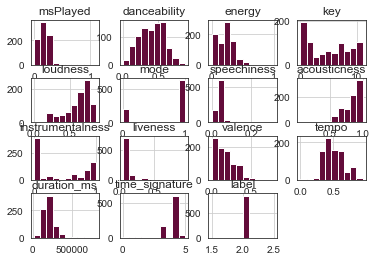

In [527]:
dataset_detailed_df[dataset_detailed_df['label']==2].hist()

In [536]:


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

definitions = ['Chill','Energetic','Cheerful','Romantic', 'lol']

X = dataset_df
y = y_kmeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

knn = KNeighborsClassifier(n_neighbors=5)
# Train the model using the training sets
knn.fit(X_train,y_train)

knn_pred =knn.predict(X_test)

confusion_matrix(y_test, knn_pred)

array([[ 720,    4,   14,   15,    3],
       [   8, 1036,    5,    1,   21],
       [  10,    9, 1166,    0,   16],
       [   6,    0,    0,  277,    0],
       [   0,   23,   22,    0,  822]])

In [535]:
classification_report(y_test,knn_pred,target_names=definitions)

              precision    recall  f1-score   support

       Chill       0.96      0.97      0.96       721
   Energetic       0.95      0.98      0.97      1074
    Cheerful       0.96      0.97      0.97      1226
    Romantic       0.99      0.94      0.96       277
         lol       0.97      0.94      0.96       880

    accuracy                           0.96      4178
   macro avg       0.97      0.96      0.96      4178
weighted avg       0.96      0.96      0.96      4178
KNN
